In [11]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import time
import datetime as dt
import matplotlib.pyplot as plt
import folium
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import math, sys
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_validate, ShuffleSplit, cross_val_score, GridSearchCV

%matplotlib inline

In [32]:
Bikes_DF = pd.read_csv(r'/content/dublinbikes_20200101_20200401.csv',error_bad_lines=False)

In [33]:
Bikes_DF.shape

(1955037, 11)

In [27]:
Bikes_DF = Bikes_DF.loc[Bikes_DF['NAME'].isin(["PRINCES STREET / O'CONNELL STREET", "HEUSTON STATION (CENTRAL)"])]

In [28]:
Bikes_DF.shape

(31882, 18)

In [29]:
Bikes_DF.head(5)
Bikes_DF.shape

(31882, 18)

In [34]:
Bikes_DF['DATETIME'] = [dt.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in Bikes_DF["TIME"]]
Bikes_DF['DATE_DT'] = [dt.datetime.date(d) for d in Bikes_DF['DATETIME']]
Bikes_DF['TIME_DT'] = [dt.datetime.time(d) for d in Bikes_DF['DATETIME']]  
Bikes_DF["DAY_DT"]=Bikes_DF.DATETIME.dt.dayofweek
Bikes_DF['HOUR_DT'] = Bikes_DF['DATETIME'].dt.hour
Bikes_DF['MIN_DT'] = Bikes_DF['DATETIME'].dt.minute

In [35]:
Bikes_DF['DATETIME'] = pd.to_datetime(Bikes_DF['DATETIME'],format='%d-%m-%Y %H:%M')
Bikes_DF['DATETIME'].min(), Bikes_DF['DATETIME'].max(), (Bikes_DF['DATETIME'].max() - Bikes_DF['DATETIME'].min())

(Timestamp('2020-01-01 06:25:02'),
 Timestamp('2020-03-24 23:55:02'),
 Timedelta('83 days 17:30:00'))

In [25]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Location_encoded = le.fit_transform(Bikes_DF['NAME'])
Bikes_DF['Location_encoded'] = Location_encoded

In [ ]:
Bikes_DF

STATION ID                 TIME  ... MIN_DT Location_encoded
4868             33  2020-01-01 06:25:02  ...     25                1
4869             33  2020-01-01 06:30:02  ...     30                1
4870             33  2020-01-01 06:35:02  ...     35                1
4871             33  2020-01-01 06:40:03  ...     40                1
4872             33  2020-01-01 06:45:02  ...     45                1
...             ...                  ...  ...    ...              ...
2221361          93  2020-04-01 23:35:02  ...     35                0
2221362          93  2020-04-01 23:40:02  ...     40                0
2221363          93  2020-04-01 23:45:02  ...     45                0
2221364          93  2020-04-01 23:50:03  ...     50                0
2221365          93  2020-04-01 23:55:02  ...     55                0

[40739 rows x 18 columns]

In [ ]:
Bikes_DF["Bike_Stand_OCC"]= (Bikes_DF["AVAILABLE BIKES"].astype(float) / Bikes_DF["BIKE STANDS"].astype(float) )*100

In [ ]:
Bikes_DF["Bike_Stand_OCC"].unique()

array([ 82.60869565,  86.95652174,  91.30434783,  95.65217391,
       100.        ,  69.56521739,  65.2173913 ,  73.91304348,
        60.86956522,  52.17391304,  43.47826087,  34.7826087 ,
        47.82608696,  39.13043478,  56.52173913,  78.26086957,
        97.5       ,  95.        ,  92.5       ,   0.        ,
         4.34782609,   8.69565217,  17.39130435,  21.73913043,
        26.08695652,  13.04347826,  30.43478261,  80.        ,
        77.5       ,  75.        ,  62.5       ,  60.        ,
        57.5       ,  55.        ,  45.        ,  40.        ,
        30.        ,  27.5       ,  25.        ,  22.5       ,
        20.        ,  17.5       ,  15.        ,   5.        ,
         7.5       ,  10.        ,  12.5       ,  32.5       ,
        35.        ,  47.5       ,  67.5       ,  70.        ,
        50.        ,  42.5       ,  37.5       ,   2.5       ,
        65.        ,  87.5       ,  82.5       ,  52.5       ,
        72.5       ,  85.        ,  90.        ])

In [ ]:
Bikes_DF_City = Bikes_DF.loc[Bikes_DF['NAME'] == "PRINCES STREET / O'CONNELL STREET"]
Bikes_DF_Heuston = Bikes_DF.loc[Bikes_DF['NAME'] == "HEUSTON STATION (CENTRAL)"]

In [ ]:
Bikes_DF_City

STATION ID                 TIME  ... Location_encoded Bike_Stand_OCC
4868             33  2020-01-01 06:25:02  ...                1      82.608696
4869             33  2020-01-01 06:30:02  ...                1      82.608696
4870             33  2020-01-01 06:35:02  ...                1      82.608696
4871             33  2020-01-01 06:40:03  ...                1      86.956522
4872             33  2020-01-01 06:45:02  ...                1      91.304348
...             ...                  ...  ...              ...            ...
2205233          33  2020-04-01 23:35:02  ...                1      86.956522
2205234          33  2020-04-01 23:40:02  ...                1      86.956522
2205235          33  2020-04-01 23:45:02  ...                1      86.956522
2205236          33  2020-04-01 23:50:03  ...                1      86.956522
2205237          33  2020-04-01 23:55:02  ...                1      86.956522

[20369 rows x 19 columns]

In [ ]:
MIN = np.array(Bikes_DF_Heuston["MIN_DT"])
OCC = np.array(Bikes_DF_Heuston["Bike_Stand_OCC"].round(0))

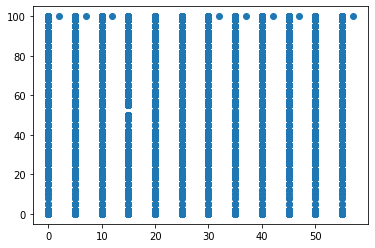

In [ ]:
#plt.xlim(50,51)
plt.scatter(MIN,OCC)

data sampling interval is 300 secs


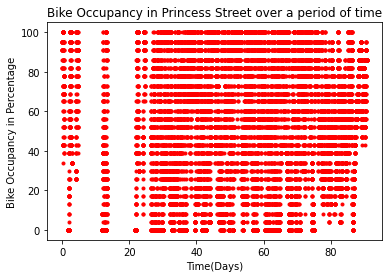

In [ ]:
start=pd.to_datetime("01−01−2020",format='%d−%m−%Y')
end=pd.to_datetime("01−04−2020",format='%d−%m−%Y')
t_full=pd.array(pd.DatetimeIndex(Bikes_DF_City.iloc[:,1]).astype(np.int64))/1000000000
dt = t_full[1]-t_full[0]
print("data sampling interval is %d secs"%dt)
t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000
t_full = np.array(t_full)
#print(t_start)
condition = (t_full>= 1577836800.0) & (t_full <= 1585699200.0)
t = np.extract(condition, t_full)
t=(t-t[0])/60/60/24
y = np.extract(condition, Bikes_DF_City.iloc[:,-1]).astype(np.int64)
plt.scatter(t,y, color='red', marker='.')
plt.title("Bike Occupancy in Princess Street over a period of time")
plt.xlabel("Time(Days)")
plt.ylabel("Bike Occupancy in Percentage")
plt.show()

data sampling interval is 300 secs


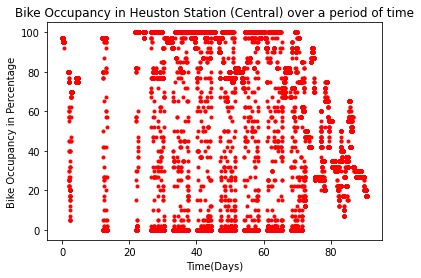

In [ ]:
t_full=pd.array(pd.DatetimeIndex(Bikes_DF_Heuston.iloc[:,1]).astype(np.int64))/1000000000
dt = t_full[1]-t_full[0]
print("data sampling interval is %d secs"%dt)
t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000
t_full = np.array(t_full)
t_start
condition = (t_full>= 1577836800.0) & (t_full <= 1585699200.0)
t = np.extract(condition, t_full)
t=(t-t[0])/60/60/24
y = np.extract(condition, Bikes_DF_Heuston.iloc[:,-1]).astype(np.int64)
plt.scatter(t,y, color='red', marker='.')
plt.title("Bike Occupancy in Heuston Station (Central) over a period of time")
plt.xlabel("Time(Days)")
plt.ylabel("Bike Occupancy in Percentage")
plt.show()

In [ ]:
Bikes_DF['lag_1'] = Bikes_DF['Bike_Stand_OCC'].shift(2) #lag for every 10 minutes
Bikes_DF['lag_2'] = Bikes_DF['Bike_Stand_OCC'].shift(6) #lag for every 30 minutes
Bikes_DF['lag_3'] = Bikes_DF['Bike_Stand_OCC'].shift(12) #lag for every 60 minutes


In [ ]:
Bikes_DF_City = Bikes_DF.loc[Bikes_DF['NAME'] == "PRINCES STREET / O'CONNELL STREET"]
Bikes_DF_Heuston = Bikes_DF.loc[Bikes_DF['NAME'] == "HEUSTON STATION (CENTRAL)"]

KeyError: ignored

In [ ]:
Bikes_DF.head(13)

Bikes_DF= Bikes_DF.drop("NAME",axis=1)
Bikes_DF= Bikes_DF.drop("ADDRESS",axis=1)
Bikes_DF =Bikes_DF.drop("TIME",axis=1)
Bikes_DF = Bikes_DF.drop("LAST UPDATED",axis=1)
Bikes_DF = Bikes_DF.drop("STATUS",axis=1)
#Bikes_DF = Bikes_DF.drop("DATETIME",axis=1)
Bikes_DF = Bikes_DF.drop("DATE_DT",axis=1)
Bikes_DF = Bikes_DF.drop("TIME_DT",axis=1)

In [ ]:
Bikes_DF["AVAILABLE BIKE STANDS"] = Bikes_DF["AVAILABLE BIKE STANDS"].astype(float)
Bikes_DF["AVAILABLE BIKES"] = Bikes_DF["AVAILABLE BIKES"].astype(float)
Bikes_DF["BIKE STANDS"] = Bikes_DF["BIKE STANDS"].astype(float)

In [ ]:
Bikes_DF

STATION ID  BIKE STANDS  ...  lag_2  lag_3
4868             33         23.0  ...    NaN    NaN
4869             33         23.0  ...    NaN    NaN
4870             33         23.0  ...    NaN    NaN
4871             33         23.0  ...    NaN    NaN
4872             33         23.0  ...    NaN    NaN
...             ...          ...  ...    ...    ...
2221361          93         40.0  ...   35.0   35.0
2221362          93         40.0  ...   35.0   35.0
2221363          93         40.0  ...   35.0   35.0
2221364          93         40.0  ...   35.0   35.0
2221365          93         40.0  ...   35.0   35.0

[40739 rows x 15 columns]

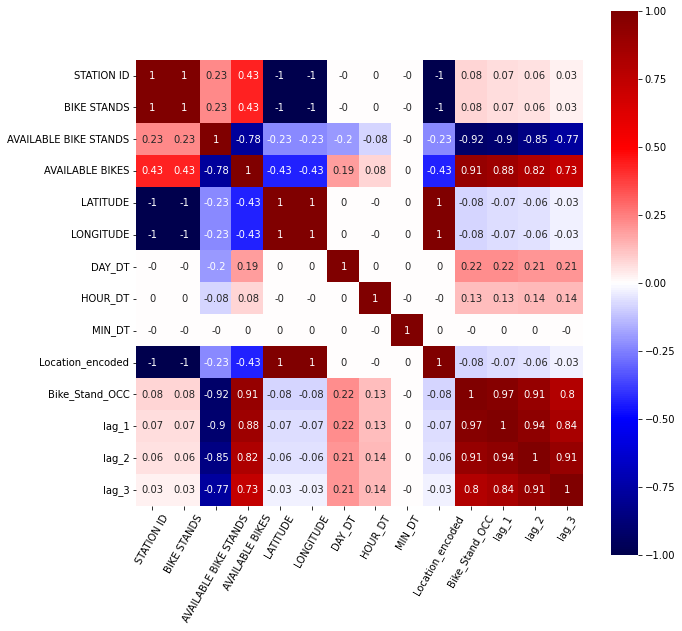

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(Bikes_DF.corr().round(2), vmin=-1, vmax=1, center=0, annot = True, annot_kws = {'size':10},square=True,
cmap='seismic')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 60)
plt.show()

In [ ]:
cor = Bikes_DF.corr()
cor_target = abs(cor["Bike_Stand_OCC"])
relevant_features = cor_target[cor_target>0.5]
relevant_features

AVAILABLE BIKE STANDS    0.920381
AVAILABLE BIKES          0.905342
Bike_Stand_OCC           1.000000
lag_1                    0.972445
lag_2                    0.907743
lag_3                    0.804980
Name: Bike_Stand_OCC, dtype: float64

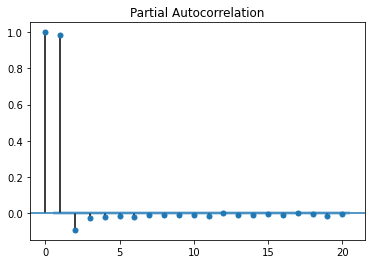

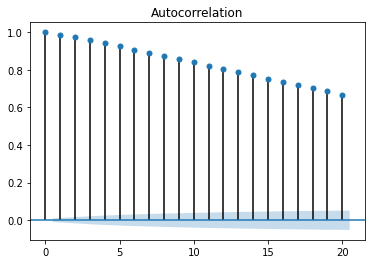

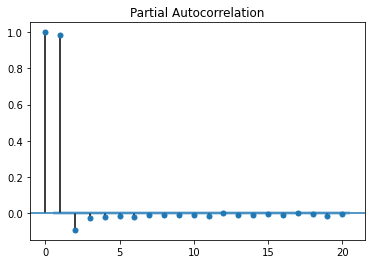

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(Bikes_DF['Bike_Stand_OCC'], lags=20)
plot_pacf(Bikes_DF['Bike_Stand_OCC'], lags=20)


In [ ]:
print(Bikes_DF.isnull().sum())
print(Bikes_DF.shape)

STATION ID                0
BIKE STANDS               0
AVAILABLE BIKE STANDS     0
AVAILABLE BIKES           0
LATITUDE                  0
LONGITUDE                 0
DATETIME                  0
DAY_DT                    0
HOUR_DT                   0
MIN_DT                    0
Location_encoded          0
Bike_Stand_OCC            0
lag_1                     2
lag_2                     6
lag_3                    12
dtype: int64
(40739, 15)


In [ ]:
#Bikes_DF=Bikes_DF[Bikes_DF.columns[[0,1,2,3,4,5,6,7,8,9,11,12,13,10]]]
Bikes_DF
Bikes_DF=Bikes_DF.dropna()
Bikes_DF


STATION ID  BIKE STANDS  ...      lag_2      lag_3
4880             33         23.0  ...  91.304348  82.608696
4881             33         23.0  ...  91.304348  82.608696
4882             33         23.0  ...  95.652174  82.608696
4883             33         23.0  ...  95.652174  86.956522
4884             33         23.0  ...  95.652174  91.304348
...             ...          ...  ...        ...        ...
2221361          93         40.0  ...  35.000000  35.000000
2221362          93         40.0  ...  35.000000  35.000000
2221363          93         40.0  ...  35.000000  35.000000
2221364          93         40.0  ...  35.000000  35.000000
2221365          93         40.0  ...  35.000000  35.000000

[40727 rows x 15 columns]

data sampling interval is 300 secs


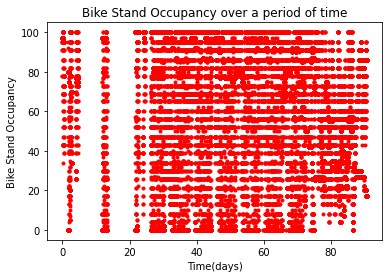

In [ ]:
t_full=pd.array(pd.DatetimeIndex(Bikes_DF.iloc[:,6]).astype(np.int64))/1000000000
dt = t_full[1]-t_full[0]
print("data sampling interval is %d secs"%dt)
t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000
t_full = np.array(t_full)
t_start
condition = (t_full>= 1577836800.0) & (t_full <= 1585699200.0)
t = np.extract(condition, t_full)
t=(t-t[0])/60/60/24
y = np.extract(condition, Bikes_DF.iloc[:,-3]).astype(np.int64)
plt.scatter(t,y, color='red', marker='.')
plt.title("Bike Stand Occupancy over a period of time")
plt.xlabel("Time(days)")
plt.ylabel("Bike Stand Occupancy")
plt.show()

In [ ]:
def test_preds(q,dd,lag,plot,model):
#q−step ahead prediction
  stride=1
  XX=y[0:y.size-q-lag*dd:stride]

  #print(XX)
  for i in range(1,lag):
    X=y[i*dd:y.size-q-(lag-i)*dd:stride]
    XX=np.column_stack((XX,X))
    yy=y[lag*dd+q::stride]; tt=t[lag*dd+q::stride]
    print("Lag Value",i)
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)
    model = model.fit(XX[train], yy[train])
    print("Model Name:",model.__class__.__name__)
    #print("Model Intercept:",model.intercept_)
    print("Model Coefficient:",model.coef_)
  y_pred = model.predict(XX)
  #print(model.score(yy[test],y_pred))
  plt.scatter(t, y, color='black',marker='.'); plt.scatter(tt, y_pred, color='blue',marker='.')
  plt.xlabel("time (days)"); plt.ylabel("bikes")
  plt.legend(["training data","predictions"],loc="upper right")
  #plt.xlim(((lag*dd+q)/day,(lag*dd+q)/day+2))
  plt.xlim(80,92)
  plt.show()
    
      


10 minutes ahead prediction using LinearRegression Model
Lag Value 1
Model Name: LinearRegression
Model Coefficient: [-0.15478037  1.13786523]
Lag Value 2
Model Name: LinearRegression
Model Coefficient: [-0.05588222 -0.07263344  1.11549582]


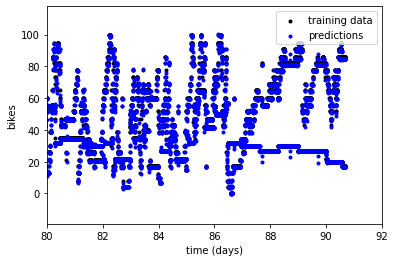

30 minutes ahead prediction using LinearRegression Model
Lag Value 1
Model Name: LinearRegression
Model Coefficient: [-0.19202641  1.15488112]
Lag Value 2
Model Name: LinearRegression
Model Coefficient: [-0.09745125 -0.08154326  1.14650529]


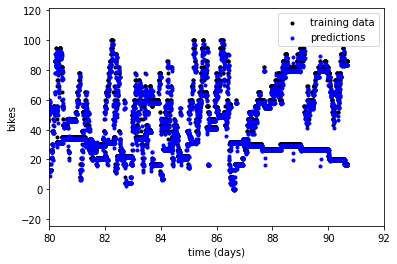

60 minutes ahead prediction using LinearRegression Model
Lag Value 1
Model Name: LinearRegression
Model Coefficient: [-0.19837017  1.13130064]
Lag Value 2
Model Name: LinearRegression
Model Coefficient: [-0.10257557 -0.09493759  1.13627934]


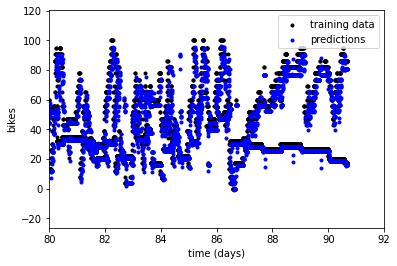

10 minutes ahead prediction using Ridge Model
Lag Value 1
Model Name: Ridge
Model Coefficient: [-0.14307904  1.12554898]
Lag Value 2
Model Name: Ridge
Model Coefficient: [-0.05184939 -0.07791325  1.11642476]


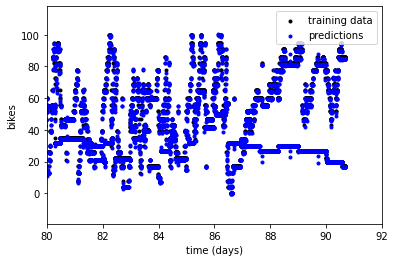

30 minutes ahead prediction using Ridge Model
Lag Value 1
Model Name: Ridge
Model Coefficient: [-0.19064637  1.1526439 ]
Lag Value 2
Model Name: Ridge
Model Coefficient: [-0.08973756 -0.08125648  1.13822102]


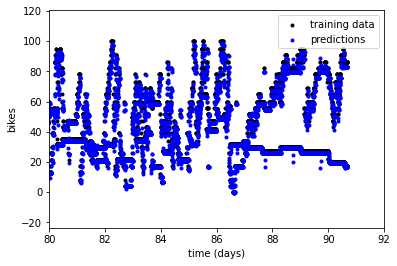

60 minutes ahead prediction using Ridge Model
Lag Value 1
Model Name: Ridge
Model Coefficient: [-0.19334098  1.12723948]
Lag Value 2
Model Name: Ridge
Model Coefficient: [-0.096487   -0.10499522  1.1391495 ]


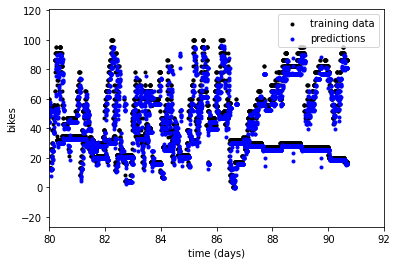

In [ ]:
plot=True
#q=2 which is 10 minute ahead prediction
models =[LinearRegression(fit_intercept=False),Ridge(fit_intercept=False)]

for mod in models:
  for i in ([2,6,12]):
    print(f"{i*5} minutes ahead prediction using {mod.__class__.__name__} Model")
    test_preds(q=i,dd=1,lag=3,plot=plot,model=mod)


In [ ]:
Bikes_DF.index = Bikes_DF.DATETIME
Train=Bikes_DF.loc['2020-01-01':'2020-03-01'] 
valid=Bikes_DF.loc['2020-03-02':'2020-04-01']

In [ ]:
#Bikes_DF = Bikes_DF.drop("DATETIME",axis=1)
Train = Train.drop("DATETIME",axis=1)
valid = valid.drop("DATETIME",axis=1)

In [ ]:
Bikes_DF

STATION ID  BIKE STANDS  ...      lag_2      lag_3
DATETIME                                      ...                      
2020-01-01 07:25:02          33         23.0  ...  91.304348  82.608696
2020-01-01 07:30:02          33         23.0  ...  91.304348  82.608696
2020-01-01 07:35:02          33         23.0  ...  95.652174  82.608696
2020-01-01 07:40:02          33         23.0  ...  95.652174  86.956522
2020-01-01 07:45:02          33         23.0  ...  95.652174  91.304348
...                         ...          ...  ...        ...        ...
2020-04-01 23:35:02          93         40.0  ...  35.000000  35.000000
2020-04-01 23:40:02          93         40.0  ...  35.000000  35.000000
2020-04-01 23:45:02          93         40.0  ...  35.000000  35.000000
2020-04-01 23:50:03          93         40.0  ...  35.000000  35.000000
2020-04-01 23:55:02          93         40.0  ...  35.000000  35.000000

[40727 rows x 15 columns]

In [ ]:
X1 = Bikes_DF.iloc[:,1]
#X2 = Bikes_DF.iloc[:,4]
X2 = Bikes_DF.iloc[:,-4]

In [ ]:
X = np.column_stack((X1, X2))
#y = np.array(Bikes_DF.iloc[:,-3]) #- 10 MIN AHEAD PREDICTION
#y = np.array(Bikes_DF.iloc[:,-2]) #- 30 MIN AHEAD PREDICTION
y = np.array(Bikes_DF.iloc[:,-1]) #- 60 MIN AHEAD PREDICTION

In [ ]:
poly_deg = [1,2,3,4,5,6,7,8]
k_list = [2,3,4,5,6,7,8]

In [ ]:
def make_poly_ft(x, deg):
    poly = PolynomialFeatures(degree=deg)
    X_poly = poly.fit_transform(x)
    return X_poly

In [ ]:
X

array([[23.        , 91.30434783],
       [23.        , 91.30434783],
       [23.        , 95.65217391],
       ...,
       [40.        , 35.        ],
       [40.        , 35.        ],
       [40.        , 35.        ]])

In [ ]:
def k_fold_cv(k, model, input_val):
    k_fold = KFold(n_splits=k)
    mean_error=[]
    std_error=[]
    temp_mae=[]
    for train, test in k_fold.split(input_val):
        c_model = model.fit(input_val[train], y[train])
        y_pred = c_model.predict(input_val[test])
        sq_error = mean_squared_error(y[test], y_pred)
        #print(sq_error)
        #mean_score = cross_val_score(c_model, input_val, y, scoring="f1", cv = 7).mean()
        #std_score = cross_val_score(c_model, input_val, y, scoring="f1", cv = 7).std()
        absolute = np.absolute(y[test] - y_pred)
        mae = np.average(absolute)
        temp_mae.append(mae)
    mean_error.append(np.array(temp_mae).mean())
    std_error.append(np.array(temp_mae).std())

    
    #print("mean error",mean_error)
    return mean_error, std_error

Linear Regression Performance with varying polynomial degree and k fold = 2


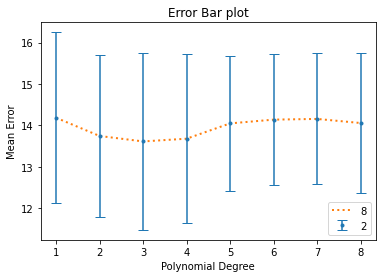

Linear Regression Performance with varying polynomial degree and k fold = 3


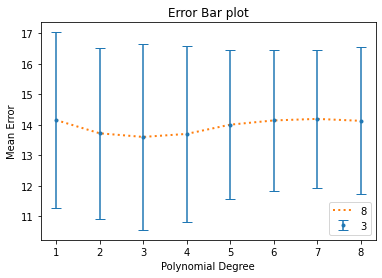

Linear Regression Performance with varying polynomial degree and k fold = 4


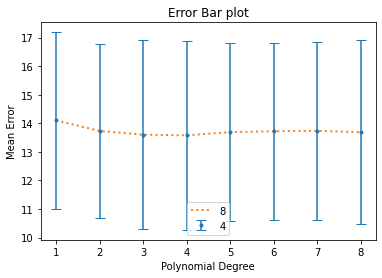

Linear Regression Performance with varying polynomial degree and k fold = 5


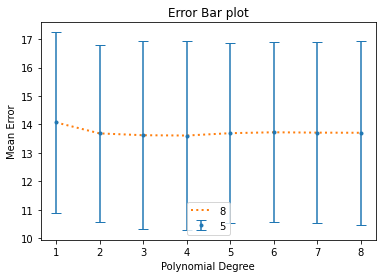

Linear Regression Performance with varying polynomial degree and k fold = 6


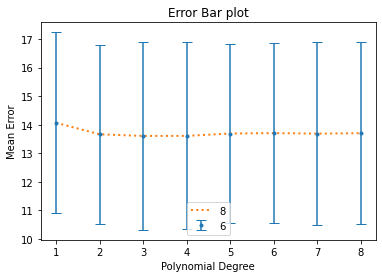

Linear Regression Performance with varying polynomial degree and k fold = 7


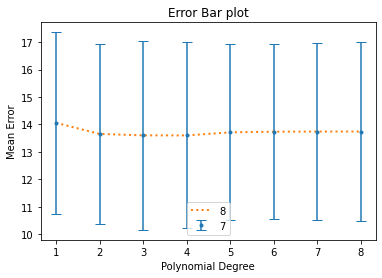

Linear Regression Performance with varying polynomial degree and k fold = 8


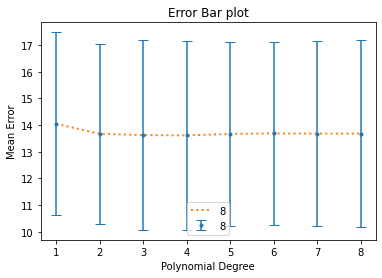

In [ ]:
for k in k_list:
  deg_means=[]
  deg_std_devs=[]
  for pd in poly_deg:
    X_polynomial=make_poly_ft(X,pd)
    LR = LinearRegression()
    LR.fit(X_polynomial,y)
    #print(X_polynomial)
    res=k_fold_cv(k,LR,X_polynomial)
    #print(res[0])
    deg_means.append(res[0])
    deg_std_devs.append(res[1])   
    #print(deg_means) 
    #print(f"Polynomial Degree = {pd} and K = {k}") 

  means = sum(deg_means,[])
  std_devs = sum(deg_std_devs,[])
    
  plt.errorbar(poly_deg, means, yerr = std_devs,fmt='.', capsize=5, label=k)
  plt.plot(poly_deg, deg_means, linestyle=':', label=pd, linewidth=2)
  plt.title("Error Bar plot")
  plt.ylabel('Mean Error')
  plt.xlabel('Polynomial Degree')  
  print(f'Linear Regression Performance with varying polynomial degree and k fold = {k}')
  plt.legend()
  plt.show()    

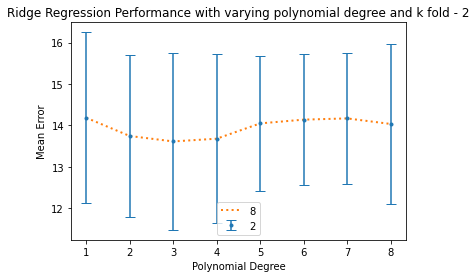

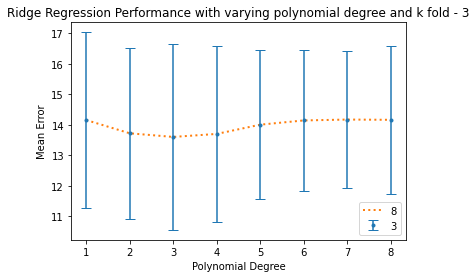

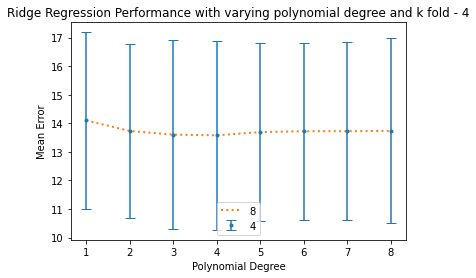

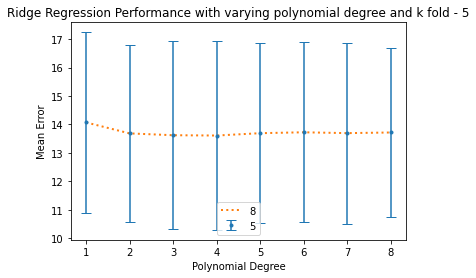

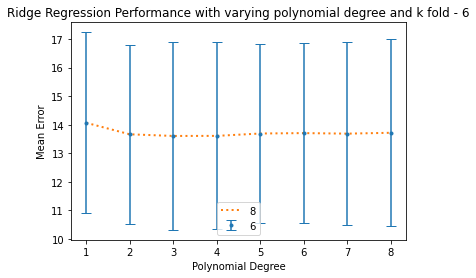

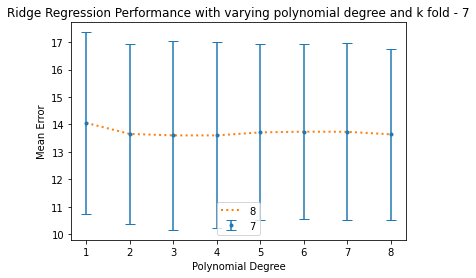

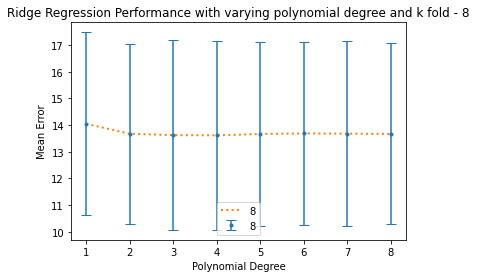

In [ ]:
for k in k_list:
  deg_means=[]
  deg_std_devs=[]
  for pd in poly_deg:
    X_polynomial=make_poly_ft(X,pd)
    Ridge_R = Ridge(alpha = 0.1)
    Ridge_R.fit(X_polynomial,y)
    #print(X_polynomial)
    res=k_fold_cv(k,Ridge_R,X_polynomial)
    #print(res[0])
    deg_means.append(res[0])
    deg_std_devs.append(res[1])   
    #print(deg_means) 
    #print(f"Polynomial Degree = {pd} and K = {k}") 
  means = sum(deg_means,[])
  std_devs = sum(deg_std_devs,[])
  
  plt.errorbar(poly_deg, means, yerr = std_devs,fmt='.', capsize=5, label=k)
  plt.plot(poly_deg, deg_means, linestyle=':', label=pd, linewidth=2)
  plt.ylabel('Mean Error')
  plt.title(f'Ridge Regression Performance with varying polynomial degree and k fold - {k}')
  plt.xlabel('Polynomial Degree')  
  plt.legend()
  plt.show()    

In [ ]:
#10 Min ahead pred
#X_poly = make_poly_ft(X,3) 
#30 Min ahead pred
X_poly = make_poly_ft(X,3) 


In [ ]:
from sklearn.metrics import accuracy_score

C = 0.1 and alpha = 5.0
Coefficient [ 0.00000000e+00 -5.32673113e-08  2.98624453e-03 -3.74137464e-06
  4.35985689e-02  1.46341828e-03 -1.58840761e-04 -6.47104171e-04
  4.44397855e-05 -1.84802251e-05]
Intercept 17.782800190252594
C = 0.5 and alpha = 1.0
Coefficient [ 0.00000000e+00 -5.72076972e-08  2.98619588e-03 -5.52043688e-06
  4.35985747e-02  1.46341756e-03 -1.58803994e-04 -6.47104276e-04
  4.44397936e-05 -1.84802222e-05]
Intercept 17.783293793467415
C = 1 and alpha = 0.5
Coefficient [ 0.00000000e+00 -6.18510928e-08  2.98617958e-03 -7.70350926e-06
  4.35985761e-02  1.46341747e-03 -1.58758884e-04 -6.47104301e-04
  4.44397946e-05 -1.84802218e-05]
Intercept 17.783899858664284
C = 10 and alpha = 0.05
Coefficient [ 0.00000000e+00 -1.81552090e-07  2.98627678e-03 -4.69136853e-05
  4.35985697e-02  1.46341739e-03 -1.57948664e-04 -6.47104201e-04
  4.44397956e-05 -1.84802215e-05]
Intercept 17.794786810120065
C = 100 and alpha = 0.005
Coefficient [ 0.00000000e+00 -8.51777683e-07  2.98305439e-03

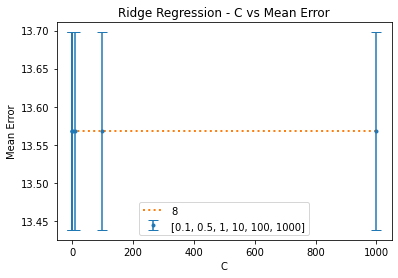

In [ ]:
C1 = [0.1, 0.5, 1, 10, 100, 1000]
means_R, std_devs_R, alphas_R =list(),list(),list()
cv = RepeatedKFold(n_splits=6, n_repeats=3, random_state=1)  
for c in C1:
  alpha = 1/(2*c)
  model = Ridge(alpha = alpha)
  model.fit(X_poly,y)
  print(f"C = {c} and alpha = {alpha}") 
  print("Coefficient",model.coef_)
  print("Intercept",model.intercept_)
  #print("Accuracy Score", accuracy_score(y,pred))
  scores = cross_val_score(model, X_poly, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
  scores = np.absolute(scores)
  means_R.append(np.mean(scores))
  std_devs_R.append(np.std(scores))
#alphas.append(alpha)
  #print(f"Polynomial Degree = {pd} and K = {k} and alpha = {alpha}") 
plt.errorbar(C1,means_R, yerr = std_devs_R,fmt='.', capsize=5, label=C1)
plt.plot(C1, means_R, linestyle=':', label=pd, linewidth=2)
plt.ylabel('Mean Error')
plt.title('Ridge Regression - C vs Mean Error')
plt.xlabel('C')  
plt.legend()
plt.show() 

In [ ]:
from statsmodels.tools.eval_measures import rmse

scores=[] #to store r squared
rmse_list=[] #to store RMSE
X_poly = make_poly_ft(X,3)
LR = LinearRegression()
# 10 Min ahead pred
#cv = KFold(n_splits=7, random_state=42, shuffle=True)
# 30 Min ahead pred
#cv = KFold(n_splits=6, random_state=42, shuffle=True)
# 1 Hour
cv = KFold(n_splits=3, random_state=42, shuffle=True)
for train_index, test_index in cv.split(X_poly):
  X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
  LR.fit(X_train, y_train)
  y_predict = LR.predict(X_test)
  scores.append(LR.score(X_test, y_test))
  rmse_fold = rmse(y_test, y_predict)
  rmse_list.append(rmse_fold)

In [ ]:
print("Linear Regression model")
print("R Squared Mean: ", np.mean(scores))
print("RMSE mean: ", np.mean(rmse_list))
print("Model Intercept:",LR.intercept_)
print("Model Coefficient:",LR.coef_)



Linear Regression model
R Squared Mean:  0.6489215462069168
RMSE mean:  21.026018013720645
Model Intercept: 14.570325210067168
Model Coefficient: [-0.12011138  0.80892324]


In [ ]:
from statsmodels.tools.eval_measures import rmse

scores=[] #to store r squared
rmse_list=[] #to store RMSE
#10 mIn ahead
#X_poly = make_poly_ft(X,3)
#10 Min ahead
#X_poly = make_poly_ft(X,6)
#10 Min ahead pred
ridge_model = Ridge(alpha = 0.5)
cv = KFold(n_splits=3, random_state=42, shuffle=True)
#30 Min ahead pred
#cv = KFold(n_splits=3, random_state=42, shuffle=True)

#60 Min ahead pred
#X_poly = make_poly_ft(X,3)
#cv = KFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in cv.split(X_poly):
  X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
  ridge_model.fit(X_train, y_train)
  y_predict = ridge_model.predict(X_test)
  scores.append(ridge_model.score(X_test, y_test))
  rmse_fold = rmse(y_test, y_predict)
  rmse_list.append(rmse_fold)
print("Ridge Regression model")
print("R Squared Mean: ", np.mean(scores))
print("RMSE mean: ", np.mean(rmse_list))
print("Model Intercept:",ridge_model.intercept_)
print("Model Coefficient:",ridge_model.coef_)

Ridge Regression model
R Squared Mean:  0.6489215462179224
RMSE mean:  21.026018013439103
Model Intercept: 14.570324816640138
Model Coefficient: [-0.12011134  0.80892323]


In [ ]:
#LSTM Model

Bikes_DF_City


MIN_DT  Bike_Stand_OCC
4868         25       82.608696
4869         30       82.608696
4870         35       82.608696
4871         40       86.956522
4872         45       91.304348
...         ...             ...
2205233      35       86.956522
2205234      40       86.956522
2205235      45       86.956522
2205236      50       86.956522
2205237      55       86.956522

[20369 rows x 2 columns]

In [ ]:
np.random.seed(7)

In [ ]:
Bikes_DF_City = Bikes_DF_City[['MIN_DT','Bike_Stand_OCC']]

In [ ]:
#10 MIN AHEAD
BIKE_OCC = Bikes_DF_City['Bike_Stand_OCC']
#BIKE_OCC = Bikes_DF_Heuston['Bike_Stand_OCC']
WS = 5

In [ ]:
def create_dataset(df, window_size = WS ):
  Bikes_city_np = df.to_numpy()
  dataX = []
  dataY = []
  for i in range(len(df)-window_size):
    row = [[a] for a in Bikes_city_np[i:i+window_size]]
    dataX.append(row)
    label = Bikes_city_np[i+window_size]
    dataY.append(label)
  return np.array(dataX), np.array(dataY)

In [ ]:
X, y = create_dataset(BIKE_OCC,WS)

In [ ]:
X.shape

(20365, 5, 1)

In [ ]:
#Dividing the dataset into training, test and future validation
X_train, y_train = X[:15000], y[:15000]
X_val, y_val = X[15000:18000], y[15000:18000]
X_test, y_test = X[18000:], y[18000:]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import *
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
# create and fit the LSTM network
model = Sequential()
model.add(InputLayer((5,1)))
model.add(LSTM(64))
model.add(Dense(8,'relu'))
model.add(Dense(1,'linear'))
model.summary()
#model.compile(loss='mean_squared_error', optimizer='adam')
#model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 64)                16896     
                                                                 
 dense_39 (Dense)            (None, 8)                 520       
                                                                 
 dense_40 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss = MeanSquaredError(),optimizer=Adam(learning_rate=0.0001), metrics = [RootMeanSquaredError()])
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100)

Epoch 1/100
469/469 [==============================] - 5s 7ms/step - loss: 5769.1392 - root_mean_squared_error: 75.9548 - val_loss: 1721.4332 - val_root_mean_squared_error: 41.4902
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 4664.4648 - root_mean_squared_error: 68.2969 - val_loss: 1104.5847 - val_root_mean_squared_error: 33.2353
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 3681.3706 - root_mean_squared_error: 60.6743 - val_loss: 716.6929 - val_root_mean_squared_error: 26.7711
Epoch 4/100
469/469 [==============================] - 3s 6ms/step - loss: 2847.2021 - root_mean_squared_error: 53.3592 - val_loss: 440.2462 - val_root_mean_squared_error: 20.9820
Epoch 5/100
469/469 [==============================] - 3s 5ms/step - loss: 2093.4998 - root_mean_squared_error: 45.7548 - val_loss: 258.1328 - val_root_mean_squared_error: 16.0665
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 1448.9923 - root_mean_s

In [ ]:
trainPredict = model.predict(X_train).flatten().reshape(-1,1)
testPredict = model.predict(X_val).flatten().reshape(-1,1)
FuturePredict = model.predict(X_test).flatten().reshape(-1,1)

In [ ]:
trainPredict

array([[97.07589 ],
       [97.07589 ],
       [97.07589 ],
       ...,
       [49.255863],
       [49.255863],
       [49.255863]], dtype=float32)

Text(0.5, 1.0, 'Training data and its predictions')

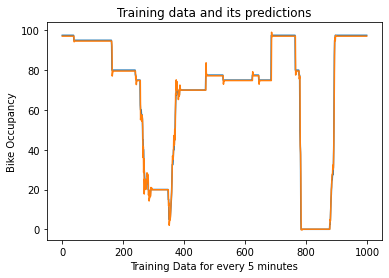

In [ ]:
plt.plot(y_train[:1000])
plt.plot(trainPredict[:1000])
plt.xlabel("Training Data for every 5 minutes")
plt.ylabel("Bike Occupancy")
plt.title('Training data and its predictions')

Text(0.5, 1.0, 'Test data and its predictions')

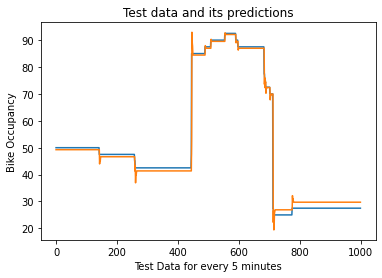

In [ ]:
plt.plot(y_val[:1000])
plt.plot(testPredict[:1000])
plt.xlabel("Test Data")
plt.ylabel("Bike Occupancy")
plt.xlabel("Test Data for every 5 minutes")
plt.ylabel("Bike Occupancy")
plt.title('Test data and its predictions')

Text(0.5, 1.0, 'Future data and its predictions')

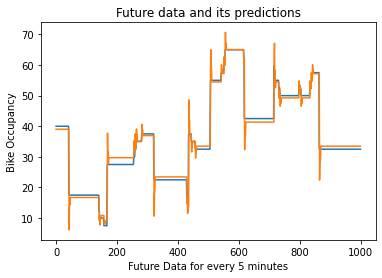

In [ ]:
plt.plot(y_test[:1000])
plt.plot(FuturePredict[:1000])
plt.xlabel("Future Data")
plt.ylabel("Bike Occupancy")
plt.xlabel("Future Data for every 5 minutes")
plt.ylabel("Bike Occupancy")
plt.title('Future data and its predictions')

In [ ]:
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)

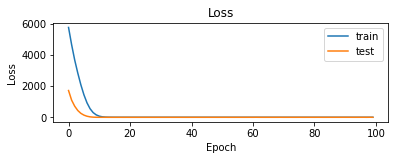

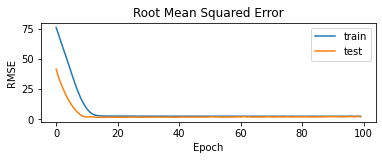

In [ ]:
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.xlabel('Epoch')
pyplot.ylabel("Loss")
pyplot.show()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Root Mean Squared Error')
pyplot.plot(history.history['root_mean_squared_error'], label='train')
pyplot.plot(history.history['val_root_mean_squared_error'], label='test')
pyplot.legend()
pyplot.xlabel('Epoch')
pyplot.ylabel("RMSE")
pyplot.show()

In [ ]:
X_train.shape

(15000, 5, 1)

In [ ]:
trainScore = mean_squared_error(trainPredict,y_train)
testScore = mean_squared_error(FuturePredict,y_test)
Score_train = np.sqrt(trainScore)
Score_test = np.sqrt(testScore)
print('Train Score: %.2f RMSE' % (Score_train))
print('Test Score: %.2f RMSE' % (Score_test))

Train Score: 2.57 RMSE
Test Score: 2.08 RMSE
